In [1]:
import os
import glob
import random
from datetime import datetime
from PIL import Image

import argparse, logging, copy
from types import SimpleNamespace
from contextlib import nullcontext

import torch
from torch import optim
import numpy as np
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import os, random
from pathlib import Path
import torchvision

from PIL import Image
from fastdownload import FastDownload
from matplotlib import pyplot as plt
from torch.utils.data import Dataset,DataLoader
import re

In [2]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2024)

workspace_dir_xy = '/kaggle/input/diffusion-dragon-word/output_dragon - 複製/'
print(len(workspace_dir_xy))

55


In [3]:
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
class Dataset(Dataset):
    def __init__(self, fnames1=None, word_encod=None, tfm=test_tfm):
        self.fnames1 = fnames1
        if self.fnames1 is not None:
            self.num_samples = len(self.fnames1)
        else:
            self.num_samples = 1
            
        self.transform = tfm
        self.word_encod = word_encod
        
    def __getitem__(self,idx):
        if self.fnames1 is not None:
            fname1 = self.fnames1[idx]
            word_x = int(fname1[len(workspace_dir_xy)+6:-4].split("-")[0])
            img_y = Image.open(fname1)
            img_y = self.transform(img_y)
            img_y = img_y.clamp(-1, 1)
            
            return word_x, img_y
        else:
            word_x = self.word_encod
            
            return word_x

    def __len__(self):
        return self.num_samples

def get_dataset(root1 = None, word_encod=None):
    if root1 is not None:
        fnames1 = sorted(glob.glob(os.path.join(root1, '*')))
        fnames1.sort(key=lambda f: int(re.sub('\D', '', f)))
        dataset = Dataset(fnames1)
        return dataset
    else:
        dataset = Dataset(None, word_encod)
        return dataset
    
import gc
gc.collect()
torch.cuda.empty_cache()

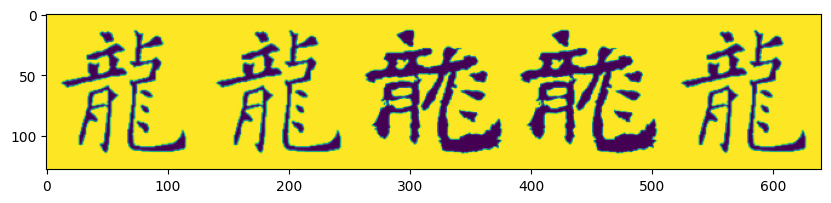

In [5]:
train_dataset = get_dataset(os.path.join(workspace_dir_xy), None)
test_dataset = get_dataset(word_encod=1)
dataloader = DataLoader(train_dataset, batch_size=7, shuffle=False,drop_last=True, pin_memory=True)

x, y = next(iter(dataloader))

images = torch.cat((y[0][0],y[1][0],y[2][0],y[3][0],y[4][0]),1)
plt.figure(figsize=(10,10))
plt.imshow(images)
plt.show()

In [6]:
def one_param(m):
    "get model first parameter"
    return next(iter(m.parameters()))

class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [7]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
                               nn.ReLU(),
                               nn.ConvTranspose2d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print('ChannelAttemtion ',self.avg_pool(x).shape)
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)
    
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [8]:
config = {  
    "run_name": "DDPM_conditional",
    "epochs": 100,
    "noise_steps":1000,
    "batch_size": 7,
    "img_size": 128,
    "num_classes": 200,
    "train_folder": "train",
    "val_folder": "test",
    "device": "cuda",
    "slice_size": 1,
    "do_validation": True,
    "lr": 5e-3,
    "workspace_dir": "./models/",
    "model_type": "diffusion"}

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, time_dim=256, remove_deep_conv=False):
        super().__init__()
        self.time_dim = time_dim
        self.remove_deep_conv = remove_deep_conv
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 256)

        if remove_deep_conv:
            self.bot1 = DoubleConv(256, 256)
            self.bot3 = DoubleConv(256, 256)
        else:
            self.bot1 = DoubleConv(256, 512)
            self.bot2 = DoubleConv(512, 512)
            self.bot3 = DoubleConv(512, 256)
            
        self.ca = ChannelAttention(256) # Attention
        self.sa = SpatialAttention()   # Attention
        
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=one_param(self).device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def unet_forwad(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x3 = self.down2(x2, t)
        x4 = self.down3(x3, t)

        x4 = self.bot1(x4)
        if not self.remove_deep_conv:
            x4 = self.bot2(x4)
        x4 = self.bot3(x4)
        
        x4 = x4*self.ca(x4)
        x4 = x4*self.sa(x4)
        
        x = self.up1(x4, x3, t)
        x = self.up2(x, x2, t)
        x = self.up3(x, x1, t)
        output = self.outc(x)
        return output
    
    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forwad(x, t)


class UNet_conditional(UNet):
    def __init__(self, config, c_in=1, c_out=1, time_dim=256, num_classes=None, **kwargs):
        super().__init__(c_in, c_out, time_dim, **kwargs)
        self.config = config
        
        if num_classes is not None:
               self.label_emb = nn.Embedding(num_classes, time_dim)
            
    def forward(self, x, t, y=None):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        batch_size = self.config["batch_size"]
        if y is not None:
            y = torch.Tensor.long(y).cuda()
            t += torch.Tensor(self.label_emb(y))
        return self.unet_forwad(x, t)

In [10]:
import math
import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
    optimizer: Optimizer,
    num_warmup_steps= int,
    num_training_steps= int,
    num_cycles: float = 0.5,
    last_epoch: int = -1,
):
    def lr_lambda(current_step):
        # Warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        # decadence
        progress = float(current_step - num_warmup_steps) / float(
            max(1, num_training_steps - num_warmup_steps)
        )
        return max(
            0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)

In [11]:
class Diffusion:
    def __init__(self, config, beta_start=1e-4, beta_end=0.02,  c_in=1, c_out=1, **kwargs):
        self.config = config
        
        self.noise_steps = self.config["noise_steps"]
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(self.config["device"])
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = self.config["img_size"]
        self.model = UNet_conditional( config, c_in, c_out, num_classes=self.config["num_classes"], **kwargs).to(self.config["device"])
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        
        self.device = self.config["device"]
        self.c_in = c_in
        self.num_classes = self.config["num_classes"]
        
        self.train_dataloader = DataLoader(train_dataset, batch_size=self.config["batch_size"], shuffle=True,drop_last=True)
        self.test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True,drop_last=True)
        
        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.config["lr"], eps=1e-5, weight_decay=0.1)
        self.scheduler = get_cosine_schedule_with_warmup(self.optimizer, 1130, 113000) 

        self.mse = nn.MSELoss()
        self.ema = EMA(0.995)
        self.scaler = torch.cuda.amp.GradScaler()
        
        self.steps = 0
        self.ckpt_dir = os.path.join(self.config["workspace_dir"], f'{self.config["model_type"]}')
        self.output = os.path.join(self.config["workspace_dir"], 'output')
        
    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def noise_images(self, x, t):
        "Add noise to images at instant t"
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def train(self, train=True):
        os.makedirs(self.ckpt_dir, exist_ok=True)
        os.makedirs(self.output, exist_ok=True)
        
        avg_loss = 0.
        old_loss = 0
        if train: self.model.train()
        else: self.model.eval()
        ''''''
        cost = []
        for e, epoch in enumerate(range(self.config["epochs"])):
            progress_bar = tqdm(self.train_dataloader)
            progress_bar.set_description(f"Epoch {e+1}")
            step = 0
            avg_loss = 0
            for i, (labels, images) in enumerate(progress_bar):
                step += 1
                with torch.autocast("cuda") and (torch.inference_mode() if not train else torch.enable_grad()):
                    images = torch.tensor(images, dtype=torch.float).to(self.device)
                    labels = torch.tensor(labels, dtype=torch.float).to(self.device)
                    t = self.sample_timesteps(images.shape[0]).to(self.device)
                    x_t, noise = self.noise_images(images, t)
                    if np.random.random() < 0.1:
                        labels = None
                    predicted_noise = self.model(x_t, t, labels)
                    loss = self.mse(noise, predicted_noise)
                    
                    #cost.append(loss)
                    
                    avg_loss += loss
                    
                    # optimization and model backwarding
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    self.ema.step_ema(self.ema_model, self.model)
                    self.scheduler.step()
                    
                    alpha = self.alpha[t][:, None, None, None]
                    alpha_hat = self.alpha_hat[t][:, None, None, None]
                    beta = self.beta[t][:, None, None, None]
                    
                    y_fake = 1 / torch.sqrt(alpha) * (x_t - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) #+ torch.sqrt(beta) * noise
                    
                    gc.collect()
                    torch.cuda.empty_cache()      
            
            cost.append(avg_loss / step)
            print("loss: ", avg_loss / step)
            
            #old_loss = float(cost[e-1]) 
            
            if float(cost[e]) <= old_loss or e == 0:
            # Save the checkpoints.
                old_loss = float(cost[e])
                torch.save(self.ema_model.state_dict(), os.path.join(self.ckpt_dir, 'Diffusion_ema.pth'))
                torch.save(self.model.state_dict(), os.path.join(self.ckpt_dir, 'Diffusion.pth'))
                print("Model improve!")
                
            if e % 50 == 0:
            # Save the checkpoints.
                torch.save(self.ema_model.state_dict(), os.path.join(self.ckpt_dir, f'Diffusion_ema_{e}.pth'))
                torch.save(self.model.state_dict(), os.path.join(self.ckpt_dir, f'Diffusion_{e}.pth'))
                print("Model saved!")   
            
        filename = os.path.join(self.ckpt_dir, 'loss.pt') 
        torch.save(torch.Tensor(cost),filename)
        
        x_epoch = np.linspace(0,self.config["epochs"],self.config["epochs"])
        plt.plot(x_epoch, torch.Tensor(cost).cpu())
        
    def inference(self, model_path):
        test_loader = self.test_dataloader
        progress_b = tqdm(test_loader)
        self.ema_model.load_state_dict(torch.load(model_path, map_location=torch.device(self.device)))
        self.ema_model.eval()
        
        for j, labels in sorted(enumerate(progress_b)):
            gc.collect()
            torch.cuda.empty_cache()
            labels = torch.tensor(labels, dtype=torch.float).to(self.device)
            
            step = 0
            x = torch.randn((1, self.c_in, self.img_size, self.img_size)).to(self.device)
            for i in reversed(range(1, self.noise_steps)):
                t = (torch.ones(x.shape[0]) * i).long().to(self.device)
                #print(t.shape, x.shape, labels.shape, t.shape)
                predicted_noise = self.ema_model(x, t, labels)

                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                #x = (x.clamp(-1, 1) + 1) / 2
                #x = x * 255
                
                if i % 100 == 0:
                    #print(x.shape)
                    step+=1
                    grid_img = x[0][0].cpu()
                    plt.imshow(grid_img, cmap='gray')
                    filename = os.path.join(self.output, 'output'+f'{step}.png')
                    #print(filename)
                    #plt.savefig(filename,bbox_inches="tight",dpi=300)
                    plt.show()
                
                gc.collect()
                torch.cuda.empty_cache()
            #filename = os.path.join(self.output, 'output'+f'{j+1}.pt')
            #torch.save(x, filename)
            del x

In [12]:
trainer = Diffusion(config)
trainer.train()

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]
/tmp/ipykernel_42/2709509981.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float).to(self.device)


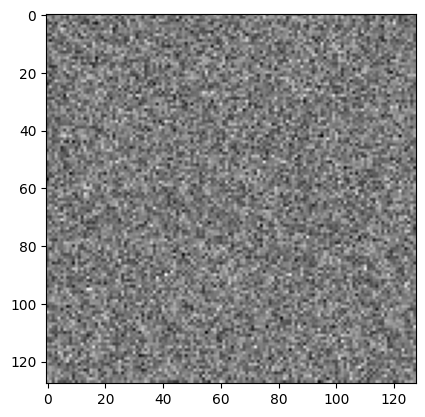

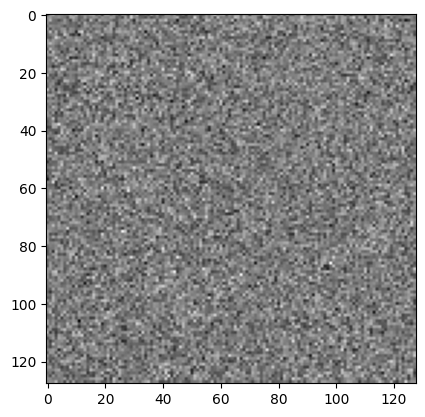

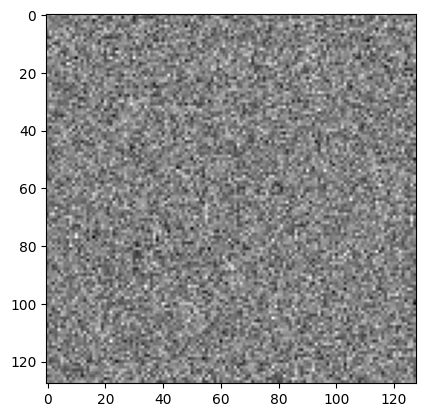

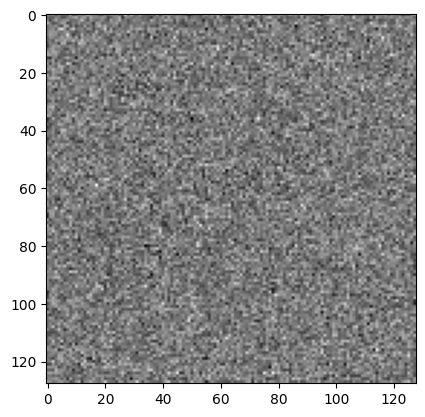

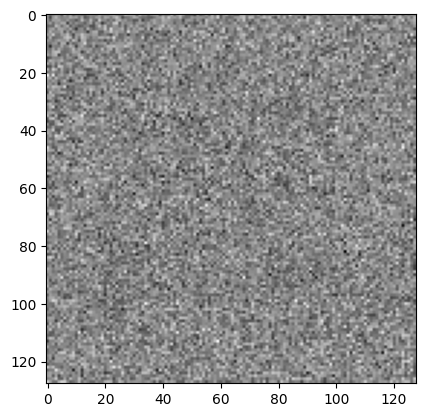

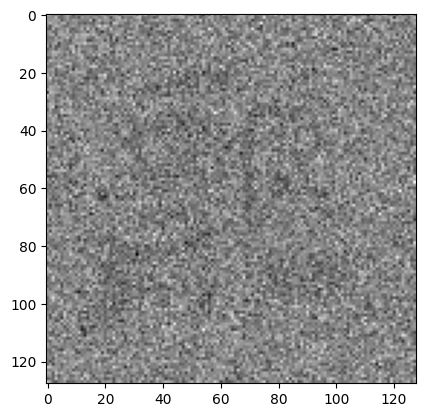

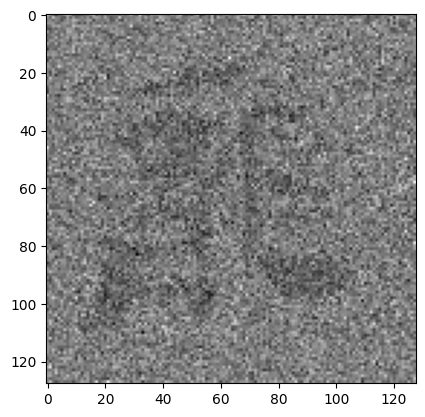

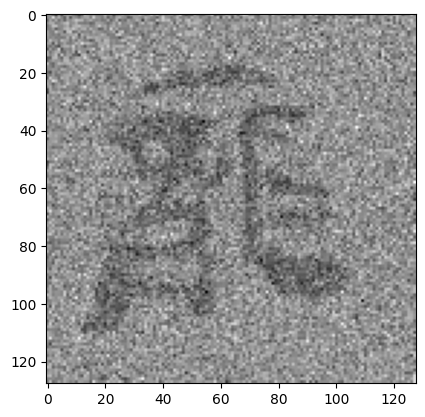

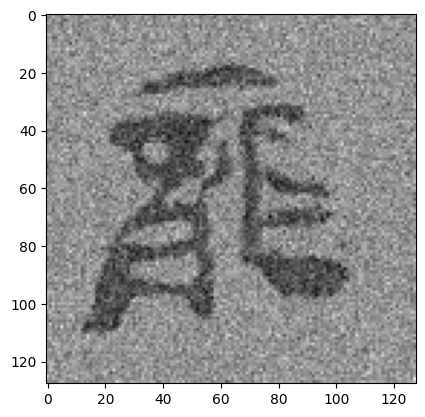

In [13]:
test_dataset = get_dataset(word_encod=0)
pred_img = trainer.inference("/kaggle/input/diffusion-model-dragon/Diffusion_ema_dragon.pth")